# Esse módulo foi criado para analisar os metadados dos arquivos de vídeos utilizados para treinar o modelo generativo e extrair informações que contribuam para decidir a arquitetura do algoritmo de aprendizado

In [2]:
import skvideo.io
import glob
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf

In [3]:
# Pegando todos os paths dos vídeos
fnames = tf.gfile.Glob("../../../../newvolume/teasers/*.mp4")
len(fnames)

615

In [4]:
from pprint import pprint
# chaves que devem ser extraídas das informações de metadados
keys = ['@width', '@height', '@duration', '@avg_frame_rate', 'filename']
teasers_metadata = []

for fname in fnames: # itera sobre a lista de paths dos vídeos
    metadata = skvideo.io.ffprobe(fname) # extrai os metadados
    if not 'video' in metadata: # se não houver metadados relacionados ao arquivo pula 
        continue
    metadata['video']['filename'] = str(fname)
    metadata = metadata['video']
    teasers_metadata.append(metadata) # cria uma lista com os metadados de todos os arquivos

# constroi um dataframe a partir da lista, com apenas as chaves desejadas
df = pd.DataFrame(teasers_metadata, columns=keys)
df.head()

,@width,@height,@duration,@avg_frame_rate,filename
0,1920,1080,60.000000,30/1,../../../../newvolume/teasers/carro aluguel_30...
1,1080,1080,15.033333,30/1,../../../../newvolume/teasers/antonio bandeira...
2,1080,1920,15.000000,22/1,../../../../newvolume/teasers/easynvest_30_180...
3,1920,1080,30.030000,30000/1001,../../../../newvolume/teasers/v1_180209_Multis...
4,1080,1080,29.988292,24000/1001,../../../../newvolume/teasers/alfamen_30_18082...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 5 columns):
@width             527 non-null object
@height            527 non-null object
@duration          527 non-null object
@avg_frame_rate    527 non-null object
filename           527 non-null object
dtypes: object(5)
memory usage: 20.7+ KB


In [5]:
# discretiza as colunas da altura e comprimento
df['@width'] = df['@width'].apply(lambda x: int(x))
df['@height'] = df['@height'].apply(lambda x: int(x))

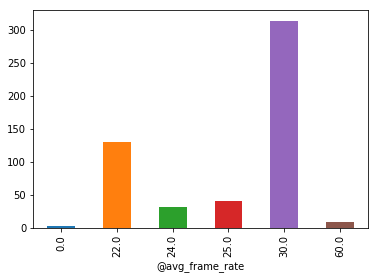

In [7]:
import math

def transform_avg_frame_rate(f_rate):
    """ 
    Método para transformar as taxas de frames que estão como strings no formato 30000/1001, por exemplo, para
    um float
    
    Paramêtros
    ----------
    f_rate: string
        A taxa média de frames
    
    Retorna
    ---------
    float
        A taxa de frames como ponto flutuante
    """
    try:
        frate = f_rate.split("/")
        num, den = float(frate[0]), float(frate[1])
        frate = num/den
        return float(round(frate))
    except:
        return 0.0
    
# aplica o metodo acima sobre todas as taxas médias de frames
df["@avg_frame_rate"] = df["@avg_frame_rate"].apply(transform_avg_frame_rate)

# agrupa por taxa de frames e soma para ter o número de vídeos de cada valor de taxa de frames
frame_rate_count = df.groupby(["@avg_frame_rate"]).size() 
frame_rate_count.plot.bar()

In [8]:
frame_rate_count.describe()

count      6.000000
mean      87.833333
std      119.920668
min        3.000000
25%       14.000000
50%       36.000000
75%      107.500000
max      314.000000
dtype: float64

In [9]:
frame_rate_count

@avg_frame_rate
0.0       3
22.0    130
24.0     32
25.0     40
30.0    314
60.0      8
dtype: int64

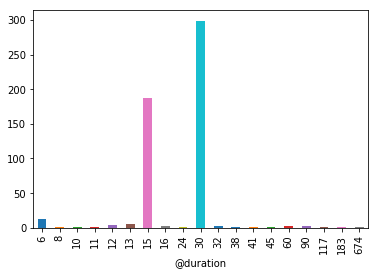

In [9]:
# arredondo todos os valores de duração de modo que sua variação diminua
# e dê pra visualizar qual é a que possui maior frequência
df["@duration"] = df["@duration"].apply(lambda x: round(x))
df_duration_count = df.groupby(['@duration']).size()
df_duration_count.plot.bar()

In [10]:
df_duration_count

@duration
6       12
8        1
10       1
11       1
12       4
13       5
15     187
16       2
24       1
30     299
32       3
38       1
41       1
45       1
60       3
90       2
117      1
183      1
674      1
dtype: int64

In [12]:
df[df["@duration"] == 674]

,@width,@height,@duration,@avg_frame_rate,filename
216,1920,1080,674,30.0,../../../../newvolume/teasers/INSTAREEL_180610...


In [11]:
df["@duration"].sum() # total em segundos de vídeos

13599

In [14]:
"""
Multiplica a duração, comprimento, altura, taxa média de frames e 3(pois os vídeos são coloridos RGB) e divido por
1000000000 para ter uma aproximação do total de gigabytes que cada vídeo ao ser decodificado vai ter
"""
df["GB"] = (df["@duration"] * df['@width'] * df['@height'] * df["@avg_frame_rate"] * 3) / 1000000000

In [15]:
df["GB"].sum()

1983.6034488

In [16]:
df["GB"].mean()

3.763953413282723

In [17]:
df["GB"].max()

125.784576

In [18]:
df["GB"].describe()

count    527.000000
mean       3.763953
std        5.870328
min        0.000000
25%        2.274480
50%        2.799360
75%        4.665600
max      125.784576
Name: GB, dtype: float64

In [19]:
"""
Mesmo cálculo feito anteriormente, mas com altura e comprimento fixos, assim como uma rede neural, 
por exemplo, esperaria.
"""
((df["@duration"] * 128 * 128 * df["@avg_frame_rate"] * 3) / 1000000000).sum()

18.436325376

In [22]:
# agrupa e soma a tupla de altura e comprimento de cada vídeo para ter o número de ocorrencias de cada resolução
df_res = df.groupby(['@width',  '@height']).size()

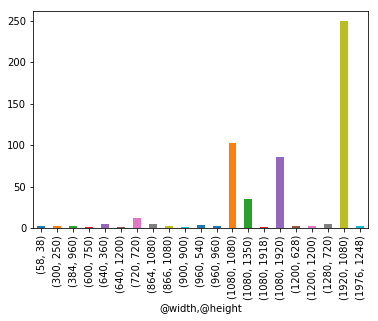

In [23]:
df_res.plot.bar()

In [24]:
df_res

@width  @height
58      38           3
300     250          2
384     960          2
600     750          1
640     360          5
        1200         1
720     720         12
864     1080         5
866     1080         2
900     900          1
960     540          4
        960          2
1080    1080       103
        1350        35
        1918         1
        1920        86
1200    628          2
        1200         2
1280    720          5
1920    1080       250
1976    1248         3
dtype: int64

In [25]:
# multiplica a duracao por taxa média de frames para obter o número de frames por vídeo
df['num_frames'] = df['@duration'] * df['@avg_frame_rate']

450.0    108
660.0     76
330.0     53
720.0     23
750.0     22
375.0     12
180.0     10
360.0     10
390.0      4
800.0      3
480.0      2
144.0      2
836.0      1
300.0      1
312.0      1
200.0      1
250.0      1
Name: num_frames, dtype: int64

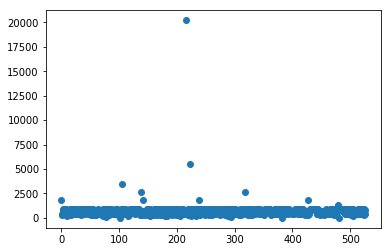

In [28]:
import matplotlib.pyplot as plt
# scatter plot para observar distribuição do total de frames
plt.scatter(df['num_frames'].index, df['num_frames'])
plt.show()

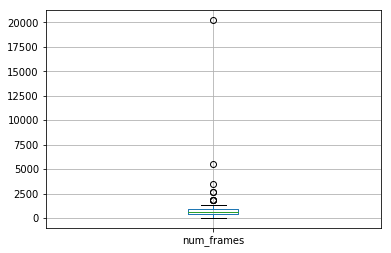

In [30]:
# boxplot para observar discrepâncias
df.boxplot(column='num_frames')

In [31]:
# filtra discrepâncias muito grandes
df['num_frames'] = df[(df['num_frames'] > 0) & (df['num_frames'] < 2500)]['num_frames']

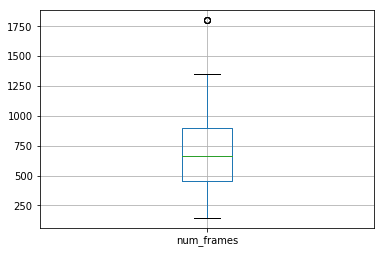

In [32]:
df.boxplot(column='num_frames')

In [33]:
df.num_frames.describe()

count     519.000000
mean      656.007707
std       251.823021
min       144.000000
25%       450.000000
50%       660.000000
75%       900.000000
max      1800.000000
Name: num_frames, dtype: float64

In [34]:
df.num_frames.mode()

0    900.0
dtype: float64